In [3]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from AnalyticCoolingCurves import LfuncN, LfuncAr, LfuncNe
from unpackConfigurations import unpackConfiguration
from unpackConfigurationsMK import unpackConfigurationMK
import ThermalFrontFormulation as TF
from LengyelReinkeFormulationMK import returnImpurityFracLengMK
import os
import pickle as pkl
from timeit import default_timer as timer

from LengyelReinkeFormulation import *
import ThermalFrontFormulation as TF

%load_ext autoreload
%autoreload 2

fontsize = 12

plt.rc('font', size=fontsize) #controls default text size
plt.rc('axes', titlesize=fontsize) #fontsize of the title
plt.rc('axes', labelsize=fontsize) #fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize) #fontsize of the x tick labels
plt.rc('ytick', labelsize=fontsize) #fontsize of the y tick labels
plt.rc('legend', fontsize=fontsize) #fontsize of the legend

def file_write(data, filename):
# Writes an object to a pickle file.
    with open(filename, "wb") as file:
    # Open file in write binary mode, dump result to file
        pkl.dump(data, file)
        
        
        
def file_read(filename):
# Reads a pickle file and returns it.
    with open(filename, "rb") as filename:
    # Open file in read binary mode, dump file to result.
        data = pkl.load(filename)
        
    return data

results = file_read("results.pkl")
print("File read")

File read


# Plot grid and SOL ring

In [3]:
gridFile = r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc"

data = dict()
data["il"] = unpackConfigurationMK(File = gridFile, Type ="il", sepadd=1)
data["ol"] = unpackConfigurationMK(File = gridFile, Type ="ol", sepadd=1)
print("Files read")

Files read


# Treat the data

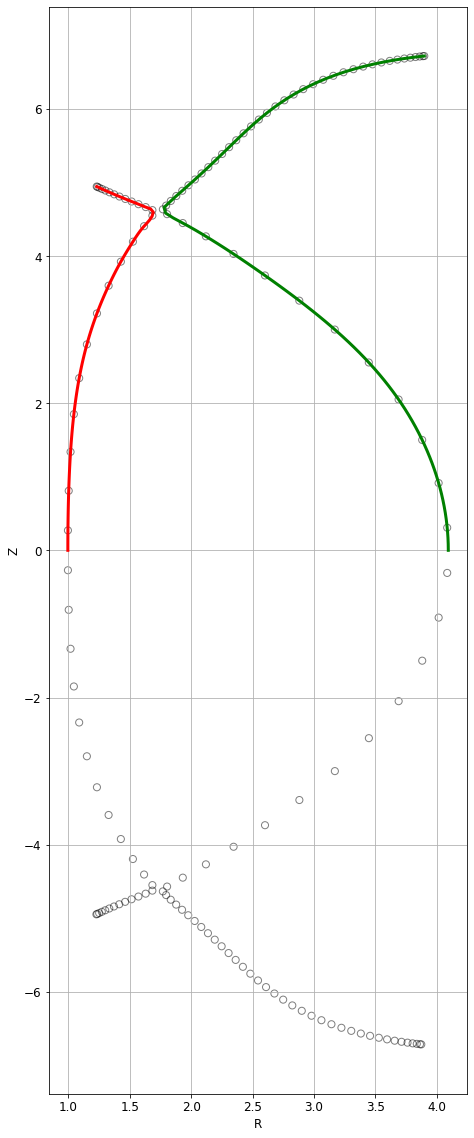

In [60]:
gridFile = r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc"
sepadd = 2

data = dict()
data["iu"] = unpackConfigurationMK(File = gridFile, Type ="iu", sepadd=sepadd)
data["ou"] = unpackConfigurationMK(File = gridFile, Type ="ou", sepadd=sepadd)

### CORRECTIONS TO MATCH RYOKO
# data["iu"]["Xpoint"] += 1

for side in data.keys():
    d = data[side]
    d["Xpoint_fromx"] = d["Xpoint"]
    d["Xpoint"] = len(d["Spol"])-d["Xpoint"]
    Xpoint = d["Xpoint"]
    
    d["indexrange"] = np.linspace(0,len(d["S"][:Xpoint])*0.98,7)
    d["indexrange"]  = list(d["indexrange"].astype(int))
    
    # d["indexrange_hires"] = np.range(d["S"][:Xpoint])
    
    # Make both B fields absolute
    for param in ["Bpol", "Btot"]:
        d[param] = abs(d[param])
        
    for param in ["Bpol", "Btot"]:
        d[param] = d[param][::-1]
        
    # Calculate distances normalised to 0 at xpoint
    for param in ["S", "Spol", "zl"]:
        d[f"{param}_fromx"] = d[param] - d[param][d["Xpoint_fromx"]] 
        
    # Sample paramters at the indices we solved DLS for. New variables: *_reduced
    for param in ["S", "Spol", "zl", "Bpol", "Btot"]:
        d[f"{param}_reduced"] = [d[param][x] for x in d["indexrange"]]
        
size = 5
fig, ax = plt.subplots(figsize=(1.5*size,4*size))
ax.scatter(data[side]["R_ring"], data[side]["Z_ring"], s = 50, edgecolor="black", color = "None", alpha = 0.5)

colors = ["red", "green"]; labels = ["inner-lower", "outer-lower"]
for i, side in enumerate(data.keys()):
    d = data[side]
    ax.plot(d["R"], d["Z"], color = colors[i], linewidth = 3, label = labels[i])
ax.set_xlabel("R")
ax.set_ylabel("Z")
ax.grid()



    

# B field profiles

## Reproduce Ryoko's figure

Text(0.5, 1.0, 'Upper-outer divertor')

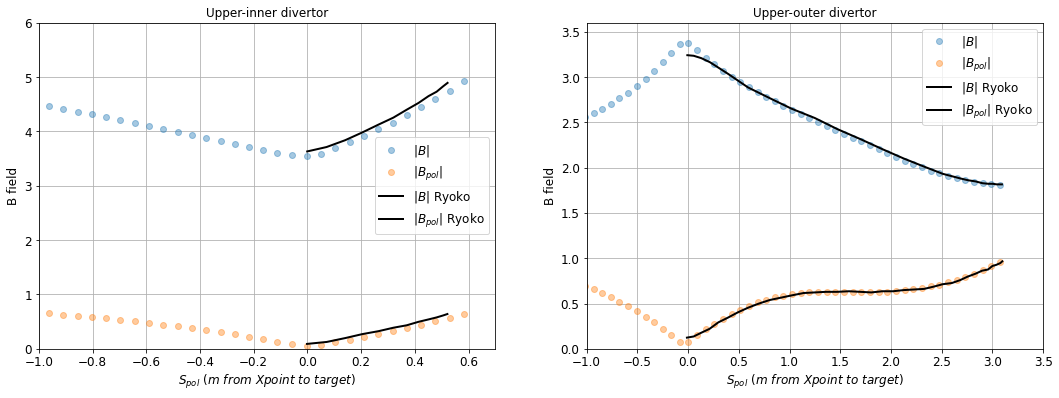

In [61]:
ryoko_dls_Btot = dict()
ryoko_dls_Bpol = dict()
ryoko_dls_Btot["iu"] = pd.read_csv(os.getcwd()+r"\\csv\\ryoko_dls_B_iu_Btot.csv", header = None)
ryoko_dls_Btot["ou"] = pd.read_csv(os.getcwd()+r"\\csv\\ryoko_dls_B_ou_Btot.csv", header = None)
ryoko_dls_Bpol["iu"] = pd.read_csv(os.getcwd()+r"\\csv\\ryoko_dls_B_iu_Bpol.csv", header = None)
ryoko_dls_Bpol["ou"] = pd.read_csv(os.getcwd()+r"\\csv\\ryoko_dls_B_ou_Bpol.csv", header = None)

fig, ax = plt.subplots(1,2, figsize=(18,6))

for i, side in enumerate(data.keys()):
    
    d = data[side]
    Xpoint = d["Xpoint"]
    # ax[i].plot(d["Spol"][Xpoint:]-d["Spol"][Xpoint], d["Btot"][Xpoint:], marker = "o", label = "$|B|$")
    # ax[i].plot(d["Spol"][Xpoint:]-d["Spol"][Xpoint], d["Bpol"][Xpoint:], marker = "o", label = "$|B_{pol}|$")
    
    ax[i].plot(d["Spol_fromx"][::-1], d["Btot"], marker = "o", label = "$|B|$", linewidth = 0, alpha = 0.4)
    ax[i].plot(d["Spol_fromx"][::-1], d["Bpol"], marker = "o", label = "$|B_{pol}|$", linewidth = 0, alpha = 0.4)
    
    ax[i].plot(ryoko_dls_Btot[side][0], ryoko_dls_Btot[side][1], label = "$|B|$ Ryoko", color = "black", linewidth = 2)
    ax[i].plot(ryoko_dls_Bpol[side][0], ryoko_dls_Bpol[side][1], label = "$|B_{pol}|$ Ryoko", color = "black", linewidth = 2)
    
    ax[i].set_xlabel("$S_{pol}\ (m\ from\ Xpoint\ to\ target)$", fontsize = 12)
    ax[i].set_ylabel("B field")
    ax[i].legend()
    ax[i].grid()
    
ax[0].set_ylim(0,6)
ax[1].set_ylim(0,3.6)
ax[0].set_xlim(-1,0.7)
ax[1].set_xlim(-1,3.5)
ax[0].set_title("Upper-inner divertor")
ax[1].set_title("Upper-outer divertor")

## Plot downstream of Xpoint in Cyd's convention

Text(0.5, 1.0, 'Upper-outer divertor')

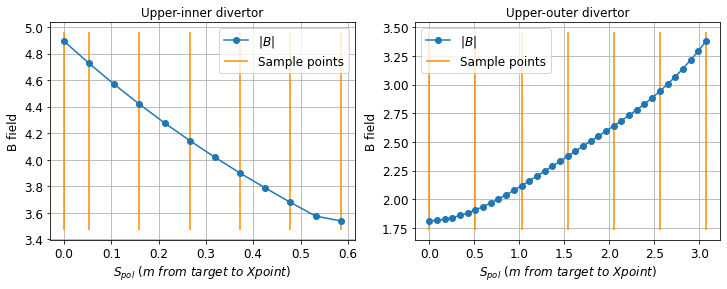

In [30]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

for i, side in enumerate(data.keys()):
    
    d = data[side]
    Xpoint = d["Xpoint"]
    
    ax[i].plot(d["Spol"][:Xpoint], d["Btot"][:Xpoint], marker = "o", label = "$|B|$")
    # ax[i].plot(d["Spol"], d["Btot"], marker = "o", label = "$|B|$")
    ylims = ax[i].get_ylim()
    ax[i].vlines(d["Spol_reduced"], ylims[0], ylims[1], color = "darkorange", label = "Sample points")
    
    ax[i].set_xlabel("$S_{pol}\ (m\ from\ target\ to\ Xpoint)$", fontsize = 12)
    ax[i].set_ylabel("B field")
    ax[i].legend()
    ax[i].grid()
    
# ax[0].set_ylim(0,5)
# ax[1].set_ylim(0,3.5)
# ax[0].set_xlim(0,0.6)
# ax[1].set_xlim(0,3.5)
ax[0].set_title("Upper-inner divertor")
ax[1].set_title("Upper-outer divertor")

In [50]:
# results = dict()

#set switches
radios = {
    "ionisation": False,  # in development
    "upstreamGrid": False, #if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "qpllu0": 5*10**9, # heat flux density at the x point
    "nu" : 1*10**19, #upstream density
    "kappa0" : 2500,
    "mi": 3*10**(-27),
    "echarge": 1.60*10**(-19), 
    "Tt": 0.5, # requested virtual target temp. Aim for low (sub 1eV) Tt
    "Lfunc": LfuncN, #impurity cooling function
    "alpha": 1000, #flux limiting alpha. Only matters if fluxlim is true
}



## Run cases

In [39]:
"{:.2f}".format(0.214124)

'0.21'

### Default settings

In [60]:
out = defaultdict(dict)

for side in data.keys():
    
    d = data[side]
    o = out[side]

    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

    o["splot"],o["C"],o["Sprofiles"],o["Tprofiles"],o["Qprofiles"],o["log"] = returnImpurityFracLeng(constants,radios,d["S"],d["indexrange"])

results["default"] = out

Solving...0...1...3...5...7...8...10...Complete in 113.8 seconds
Solving...0...6...12...18...24...30...36...Complete in 112.2 seconds


### Default with upstreamgrid=True

In [51]:
out = defaultdict(dict)

for side in data.keys():
    
    d = data[side]
    o = out[side]
    radios["upstreamGrid"] = True
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

    o["splot"],o["C"],o["Sprofiles"],o["Tprofiles"],o["Qprofiles"],o["log"] = returnImpurityFracLeng(constants,radios,d["S"],d["indexrange"])

results["upstreamgrid"] = out

Solving...0...1...3...5...7...8...10...Complete in 210.3 seconds
Solving...0...6...12...18...24...30...36...Complete in 262.7 seconds


### Feed up to Xpoint+5

In [4]:
out = defaultdict(dict)

for side in data.keys():
    
    d = data[side]
    o = out[side]

    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

    o["splot"],o["C"],o["Sprofiles"],o["Tprofiles"],o["Qprofiles"],o["log"] = returnImpurityFracLeng(constants,radios,d["S"][:d["Xpoint"]+5],d["indexrange"])

results["Xtrim"] = out

Solving...0...1...3...5...7...8...10...Complete in 86.8 seconds
Solving...0...6...12...18...24...30...36...Complete in 151.5 seconds


### Feed up to Xpoint+5 hires

In [38]:
out = defaultdict(dict)

for side in data.keys():
    
    d = data[side]
    o = out[side]

    indexrange = range(len(d["S"][:d["Xpoint"]]))
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

    o["splot"],o["C"],o["Sprofiles"],o["Tprofiles"],o["Qprofiles"],o["log"] = returnImpurityFracLengMK(
        constants,radios,d["S"][:d["Xpoint"]+5],indexrange, tol = 1e-3, acceleration = 3)

results["Xtrimhires"] = out

Solving...0...1...2...3...4...5...6...7...8...9...10...Complete in 17.0 seconds
Solving...0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...Complete in 61.3 seconds


In [34]:
indexrange

[0, 1, 3, 4, 6, 8, 9, 11, 12, 14, 16]

In [31]:
d["S"][:d["Xpoint"]+5]

array([0.        , 0.25665264, 0.51332244, 0.77002123, 1.02676109,
       1.28355435, 1.54041356, 1.79735157, 2.05438149, 2.31151673,
       2.56877097, 2.82615825, 3.0836929 , 3.34138962, 3.59926346,
       3.85732984])

### Feed up to xpoint+1

In [13]:
out = defaultdict(dict)

for side in data.keys():
    
    d = data[side]
    o = out[side]

    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

    o["splot"],o["C"],o["Sprofiles"],o["Tprofiles"],o["Qprofiles"],o["log"] = returnImpurityFracLeng(constants,radios,d["S"][:d["Xpoint"]+1],d["indexrange"])

results["Xtrim_closer"] = out

Solving...0...1...3...5...7...8...10...Complete in 149.2 seconds
Solving...0...6...12...18...24...30...36...Complete in 245.2 seconds


### Tt = 0.5eV

In [55]:
out = defaultdict(dict)

for side in data.keys():
    
    d = data[side]
    o = out[side]

    constants["Tt"] = 1
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

    o["splot"],o["C"],o["Sprofiles"],o["Tprofiles"],o["Qprofiles"],o["log"] = returnImpurityFracLeng(constants,radios,d["S"],d["indexrange"])

results["Tt1"] = out

Solving...0...1...3...5...7...8...10...Complete in 116.8 seconds
Solving...0...6...12...18...24...30...36...Complete in 111.5 seconds


### Allow upstream of xpoint

In [83]:
out = defaultdict(dict)

for side in data.keys():
    t0 = timer()    
    d = data[side]
    o = out[side]
    
    constants["upstreamGrid"] = True
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

    o["splot"],o["C"],o["Sprofiles"],o["Tprofiles"],o["Qprofiles"],o["log"] = returnImpurityFracLeng(constants,radios,d["S"],d["indexrange"])

results["upstream"] = out

Solving...0...1...3...5...7...9...11...Complete.
Solving...0...6...12...18...24...30...36...Complete.


### Argon cooling curve

In [55]:
out = defaultdict(dict)

for side in data.keys():
    
    d = data[side]
    o = out[side]
    
    constants["upstreamGrid"] = True
    constants["Lfunc"] = LfuncAr
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

    o["splot"],o["C"],o["Sprofiles"],o["Tprofiles"],o["Qprofiles"],o["log"] = returnImpurityFracLeng(constants,radios,d["S"],d["indexrange"])

results["Ar"] = out

Solving...0...1...3...5...7...9...11...Complete in 176.2 seconds
Solving...0...6...12...18...24...30...36...Complete in 145.5 seconds


### Neon cooling curve

In [128]:
out = defaultdict(dict)

for side in data.keys():
    
    d = data[side]
    o = out[side]
    
    constants["upstreamGrid"] = True
    constants["Lfunc"] = LfuncNe
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

    o["splot"],o["C"],o["Sprofiles"],o["Tprofiles"],o["Qprofiles"],o["log"] = returnImpurityFracLeng(constants,radios,d["S"],d["indexrange"])

results["Ne"] = out

Solving...0...1...3...5...7...9...11...Complete in 184.1 seconds
Solving...0...6...12...18...24...30...36...Complete in 167.0 seconds


### Looser error tolerance

In [54]:
out = defaultdict(dict)

for side in data.keys():

    d = data[side]
    o = out[side]

    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
    tol = 0.01
    o["splot"],o["C"],o["Sprofiles"],o["Tprofiles"],o["Qprofiles"],o["log"] = returnImpurityFracLeng(constants,radios,d["S"],d["indexrange"], Ctol = tol, Ttol = tol)

results["tol0.01"] = out

Solving...0...1...3...5...7...9...11...Complete in 42.0 seconds
Solving...0...6...12...18...24...30...36...Complete in 26.5 seconds


In [54]:
results.keys()

dict_keys(['default', 'hinu_loq', 'upstream', 'tol0.01', 'Ar', 'tol0.1', 'loq'])

In [15]:
file_write(results, "results.pkl")
print("File written")

File written


### Case with low power

In [52]:
out = defaultdict(dict)

for side in data.keys():
    
    d = data[side]
    o = out[side]

    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
    constants["nu"] = 1e19 * 5
    constants["qpllu0"] = 50e6 * 35 # 50MW/m2 * 35m of OMP-Xpoint distance

    o["splot"],o["C"],o["Sprofiles"],o["Tprofiles"],o["Qprofiles"],o["log"] = returnImpurityFracLeng(constants,radios,d["S"],d["indexrange"])

results["loq"] = out

Solving...0...1...3...5...7...8...10...Complete in 149.5 seconds
Solving...0...6...12...18...24...30...36...Complete in 136.4 seconds


### Case with realistic inputs

In [14]:
# From Ryoko, email from 22/03/2022:
# Yes, I mainly used for the cases I sent.

# nu = 1.0e20; (m^{-3})

# qpllu = 1.0e9; (W/m^2)

In [52]:
out = defaultdict(dict)

for side in data.keys():
    
    d = data[side]
    o = out[side]

    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
    constants["nu"] = 1e20
    constants["qpllu0"] = 1.0e9 # 50MW/m2 * 35m of OMP-Xpoint distance

    o["splot"],o["C"],o["Sprofiles"],o["Tprofiles"],o["Qprofiles"],o["log"] = returnImpurityFracLengMK(constants,radios,d["S"],d["indexrange"], verbose = False)

results["realinputs"] = out

Solving...cz: 0.08, error1: 2.0382E-01
cz: 0.04, error1: -1.638E-01
Bounds centering enabled, set to 2 iterations
-->Before centering: 0.039-0.078
-->After centering: 0.039-0.078
>Bounds: 0.039-0.058, cz: 0.058, error1: 3.602E-02
>Bounds: 0.049-0.058, cz: 0.049, error1: -5.873E-02
>Bounds: 0.053-0.058, cz: 0.053, error1: -1.025E-02
>Bounds: 0.053-0.056, cz: 0.056, error1: 1.314E-02
>Bounds: 0.053-0.055, cz: 0.055, error1: 1.514E-03
>Bounds: 0.054-0.055, cz: 0.054, error1: -4.351E-03
>Bounds: 0.054-0.055, cz: 0.054, error1: -1.414E-03
>Bounds: 0.054-0.054, cz: 0.054, error1: 5.070E-05
>Bounds: 0.054-0.054, cz: 0.054, error1: -6.815E-04
>Bounds: 0.054-0.054, cz: 0.054, error1: -3.153E-04
>Bounds: 0.054-0.054, cz: 0.054, error1: -1.322E-04
>Bounds: 0.054-0.054, cz: 0.054, error1: -4.077E-05
>Bounds: 0.054-0.054, cz: 0.054, error1: 4.979E-06
-----------error0: 2.082E-02, Tu: 139.95

cz: 0.05, error1: -2.1433E-02
cz: 0.11, error1: 4.038E-01
Bounds centering enabled, set to 2 iterations
-->B

KeyboardInterrupt: 

## Save and load results

In [23]:
file_write(results, "results.pkl")
print("File written")

File written


In [24]:
results = file_read("results.pkl")
print("File read")

File read


### Original DLS

In [9]:
# #range of indices to choose for front position
# indexrange = np.linspace(0,len(d["S"])-1000,5)
# indexrange = list(indexrange.astype(int))

# PASS ONLY DATA UP TO X POINT
out_tfx = defaultdict(dict)
for side in data.keys():

    #calculate C using simpler thermal front model
    d = data[side]
    o = out_tfx[side]
    Xpoint = d["Xpoint"]
    
    o["C"] = []
    for i in range(0,d["Xpoint"]):
        o["C"].append(TF.CfInt(d["S"][:Xpoint], d["Btot"][:Xpoint], 
                           d["S"][Xpoint], #Xpoint
                           d["S"][:Xpoint][-1], # Total parallel length
                           sh = d["S"][i], kappa1=2500))    
    o["Crel"] = o["C"]/o["C"][0]

#PASS ALL DATA
out_tf = defaultdict(dict)
for side in data.keys():

    #calculate C using simpler thermal front model
    d = data[side]
    o = out_tf[side]
    Xpoint = d["Xpoint"]
    
    o["C"] = []
    for i in range(0,d["Xpoint"]):
        o["C"].append(TF.CfInt(d["S"], d["Btot"], 
                           d["S"][Xpoint], #Xpoint
                           d["S"][-1], # Total parallel length
                           sh = d["S"][i], kappa1=2500))
    o["Crel"] = o["C"]/o["C"][0]
    
print("Complete")

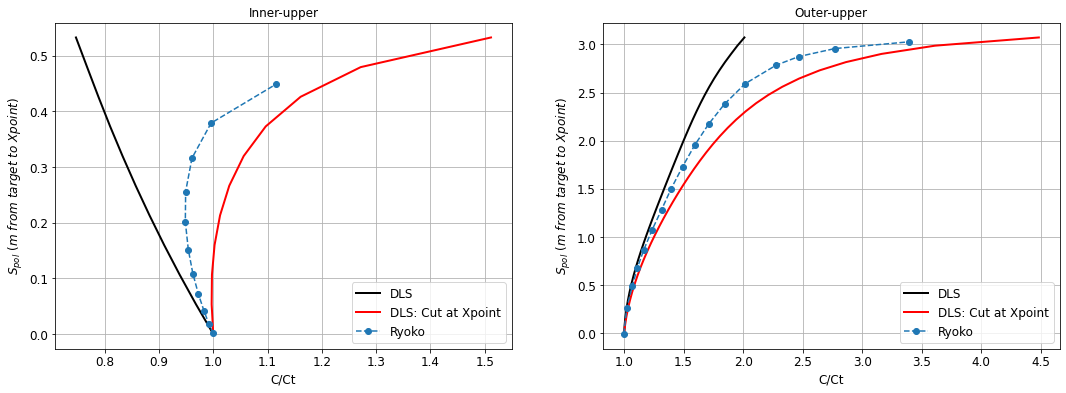

In [37]:
ryoko_dls = dict()
ryoko_dls["iu"] = pd.read_csv(os.getcwd()+r"\\csv\\ryoko_dls_iu.csv", header = None)
ryoko_dls["ou"] = pd.read_csv(os.getcwd()+r"\\csv\\ryoko_dls_ou.csv", header = None)


fig, ax = plt.subplots(1,2,figsize=(18,6))
ax[0].set_title("Inner-upper"); ax[1].set_title("Outer-upper")

for i, side in enumerate(data.keys()):
    out = results["default"]
    d = data[side]
    
    ax[i].plot(out_tf[side]["Crel"], data[side]["Spol"][:d["Xpoint"]], label = "DLS", linewidth = 2, color = "black")
    ax[i].plot(out_tfx[side]["Crel"], data[side]["Spol"][:d["Xpoint"]], label = "DLS: Cut at Xpoint", linewidth = 2, color = "red")
    
    ax[i].plot(ryoko_dls[side][0], ryoko_dls[side][1], marker = "o", label = "Ryoko", linestyle = "dashed")
    
    ax[i].set_xlabel("C/Ct")
    ax[i].set_ylabel("$S_{pol}\ (m\ from\ target\ to\ Xpoint)$")
    ax[i].grid()
    ax[i].legend()
    
    

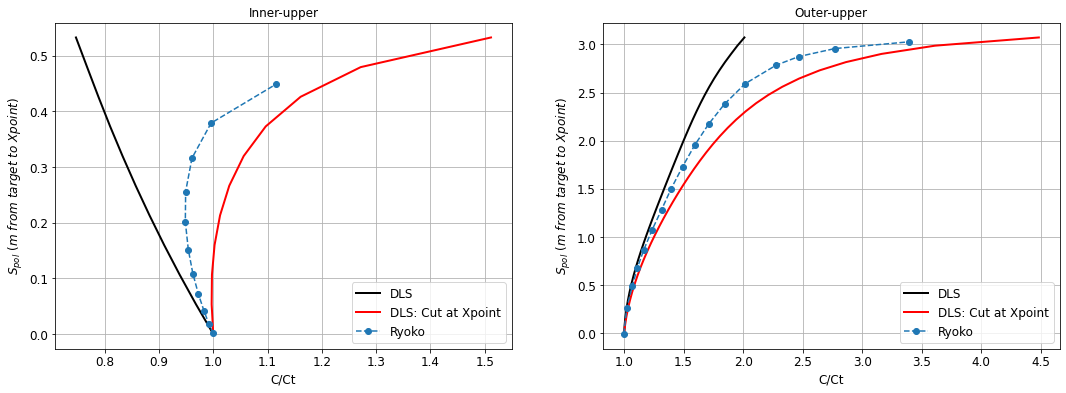

In [34]:
ryoko_dls = dict()
ryoko_dls["iu"] = pd.read_csv(os.getcwd()+r"\\csv\\ryoko_dls_iu.csv", header = None)
ryoko_dls["ou"] = pd.read_csv(os.getcwd()+r"\\csv\\ryoko_dls_ou.csv", header = None)


fig, ax = plt.subplots(1,2,figsize=(18,6))
ax[0].set_title("Inner-upper"); ax[1].set_title("Outer-upper")

for i, side in enumerate(data.keys()):
    out = results["default"]
    d = data[side]
    
    ax[i].plot(out_tf[side]["Crel"], data[side]["Spol"][:d["Xpoint"]], label = "DLS", linewidth = 2, color = "black")
    ax[i].plot(out_tfx[side]["Crel"], data[side]["Spol"][:d["Xpoint"]], label = "DLS: Cut at Xpoint", linewidth = 2, color = "red")
    
    ax[i].plot(ryoko_dls[side][0], ryoko_dls[side][1], marker = "o", label = "Ryoko", linestyle = "dashed")
    
    ax[i].set_xlabel("C/Ct")
    ax[i].set_ylabel("$S_{pol}\ (m\ from\ target\ to\ Xpoint)$")
    ax[i].grid()
    ax[i].legend()
    
    

## Treat and plot output data

In [40]:
for case in results.keys():
    for side in data.keys():
        o = results[case][side]
        d = data[side]
        o["Crel"] = o["C"]/o["C"][0]

ryoko_dls = dict(); ryoko_LRB = dict()
ryoko_dls["iu"] = pd.read_csv(os.getcwd()+r"\\csv\\ryoko_dls_iu.csv", header = None)
ryoko_dls["ou"] = pd.read_csv(os.getcwd()+r"\\csv\\ryoko_dls_ou.csv", header = None)
ryoko_LRB["iu"] = [[1,0.9953, 0.9893, 0.9827, 0.9765, 0.9715, 0.9694, 0.9724, 0.9856, 1.0206, 1.1242],
[0, 0.0799, 0.1481, 0.2139, 0.2755, 0.3322, 0.3835, 0.4286, 0.4669, 0.4977, 0.5215]]

### Cutting at xpoint, DLS vs. RLB vs. Ryoko

NameError: name 'data' is not defined

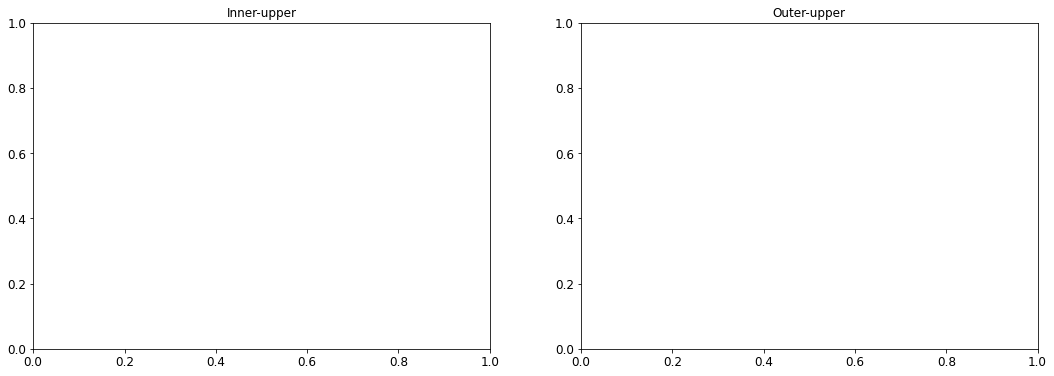

In [4]:
fig, ax = plt.subplots(1,2,figsize=(18,6))
ax[0].set_title("Inner-upper"); ax[1].set_title("Outer-upper")
for i, side in enumerate(data.keys()):
    d = data[side]
    out = results["default"]
    # ax[i].plot(out[side]["Crel"], data[side]["Spol_reduced"], label = "Reinke: default", linewidth = 2)
    out = results["Xtrim"]
    ax[i].plot(out[side]["Crel"], data[side]["Spol_reduced"], label = "Reinke: Cut at Xpoint", linewidth = 2)
    # ax[i].plot(out_tf[side]["Crel"], data[side]["Spol"][:d["Xpoint"]], label = "DLS", linewidth = 2)
    # ax[i].plot(out_tfx[side]["Crel"], data[side]["Spol"][:d["Xpoint"]], label = "DLS: Cut at Xpoint", linewidth = 2)
    # ax[i].plot(ryoko_dls[side][0], ryoko_dls[side][1], marker = "o", label = "DLS: Ryoko", linestyle = "dashed")
    ax[i].set_xlabel("C/Ct")
    ax[i].set_ylabel("$S_{pol}\ (m\ from\ target\ to\ Xpoint)$")
    ax[i].grid()
    ax[i].legend()
ax[0].plot(ryoko_LRB["iu"][0], ryoko_LRB["iu"][1], marker = "o", label = "Reinke: Ryoko", linestyle = "dashed")

In [5]:
results["default"]["iu"]["splot"]

[0.0,
 0.2566526413436028,
 0.7700212307822514,
 1.2835543468697383,
 1.7973515716053934,
 2.0543814931484516,
 2.568770972317794]

### RLB: different xpoint cuts

ValueError: x and y must have same first dimension, but have shapes (7,) and (11,)

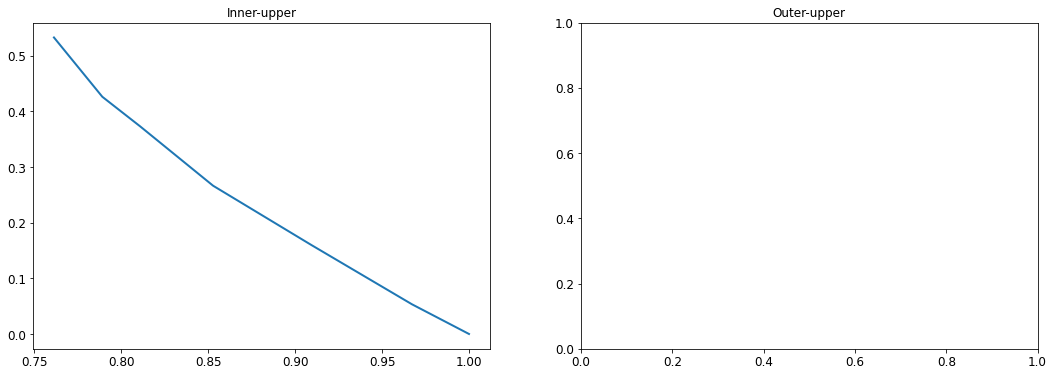

In [49]:
fig, ax = plt.subplots(1,2,figsize=(18,6))

ax[0].set_title("Inner-upper"); ax[1].set_title("Outer-upper")
for i, side in enumerate(data.keys()):
    d = data[side]
    out = results["default"]
    ax[i].plot(out[side]["Crel"], data[side]["Spol_reduced"], label = "Reinke: to midpoint", linewidth = 2)
    out = results["Xtrim"]
    ax[i].plot(out[side]["Crel"], [data[side]["Spol"][x] for x in range(len(d["Spol"][:d["Xpoint"]]))], label = "Reinke: to xpoint-5", linewidth = 2)
    out = results["Xtrimhires"]
    ax[i].plot(out[side]["Crel"], data[side]["Spol_reduced"], label = "Reinke: to xpoint-5 hires", linewidth = 2)
    out = results["Xtrim_closer"]
    ax[i].plot(out[side]["Crel"], data[side]["Spol_reduced"], label = "Reinke: to xpoint-1", linewidth = 2)
    ax[i].set_xlabel("C/Ct")
    ax[i].set_ylabel("$S_{pol}\ (m\ from\ target\ to\ Xpoint)$")
    ax[i].grid()
    ax[i].legend() 
ax[0].plot(ryoko_LRB["iu"][0], ryoko_LRB["iu"][1], marker = "o", label = "Reinke: Ryoko", linestyle = "dashed")


In [43]:
[data[side]["Spol"][x] for x in range(data[side]["Spol"][:Xpoint])]

TypeError: only integer scalar arrays can be converted to a scalar index

In [46]:
data[side]["Spol"][:data[side]["Xpoint"]]

array([0.        , 0.05326055, 0.10652118, 0.15978185, 0.21304253,
       0.26630318, 0.3195638 , 0.37282436, 0.42608487, 0.47934532,
       0.53260573])

## Realistic inputs

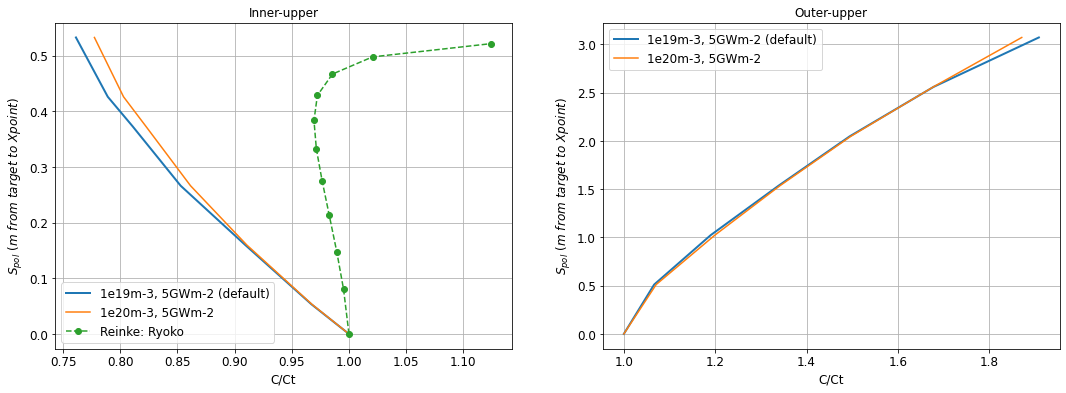

In [27]:
 

fig, ax = plt.subplots(1,2,figsize=(18,6))
ax[0].set_title("Inner-upper"); ax[1].set_title("Outer-upper")

for i, side in enumerate(data.keys()):
    
    d = data[side]
    
    out = results["default"]
    ax[i].plot(out[side]["Crel"], data[side]["Spol_reduced"], label = "1e19m-3, 5GWm-2 (default)", linewidth = 2)

    
    out = results["realinputs"]
    ax[i].plot(out[side]["Crel"], data[side]["Spol_reduced"], label = "1e20m-3, 5GWm-2")
    
#     out = results["upstream"]
#     ax[i].plot(out[side]["Crel"], data[side]["Spol_reduced"], marker = "x", label = "Upstream allowed")
    
#     out = results["Ar"]
#     ax[i].plot(out[side]["Crel"], data[side]["Spol_reduced"], marker = "s", label = "Argon curve")

    # out = results["Tt1"]
    # ax[i].plot(out[side]["Crel"], data[side]["Spol_reduced"], marker = "v", label = "Tt = 1eV")

    # out = results["loq"]
    # ax[i].plot(out[side]["Crel"], data[side]["Spol_reduced"], marker = "v", label = "Lower q")
    
    # ax[i].plot(out_tf[side]["Crel"], data[side]["Spol"][:d["Xpoint"]], label = "DLS", linewidth = 2)
    # ax[i].plot(out_tfx[side]["Crel"], data[side]["Spol"][:d["Xpoint"]], label = "DLS: Cut at Xpoint", linewidth = 2)
    
    # ax[i].plot(ryoko_dls[side][0], ryoko_dls[side][1], marker = "o", label = "DLS: Ryoko", linestyle = "dashed")
    
    ax[i].set_xlabel("C/Ct")
    ax[i].set_ylabel("$S_{pol}\ (m\ from\ target\ to\ Xpoint)$")
    ax[i].grid()
    
    
ax[0].plot(ryoko_LRB["iu"][0], ryoko_LRB["iu"][1], marker = "o", label = "Reinke: Ryoko", linestyle = "dashed")
ax[1].legend()
ax[0].legend()
    
    

In [49]:
results.keys()

dict_keys(['default', 'hinu_loq', 'upstream', 'tol0.01', 'Ar', 'tol0.1'])

# Scans

In [ ]:
out = defaultdict(dict)

for i, power in ["

for side in data.keys():
    
    d = data[side]
    o = out[side]

    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
    constants["nu"] = 1e19 * 5
    constants["qpllu0"] = 50e6 * 35 # 50MW/m2 * 35m of OMP-Xpoint distance

    o["splot"],o["C"],o["Sprofiles"],o["Tprofiles"],o["Qprofiles"],o["log"] = returnImpurityFracLeng(constants,radios,d["S"],d["indexrange"])

results["loq"] = out

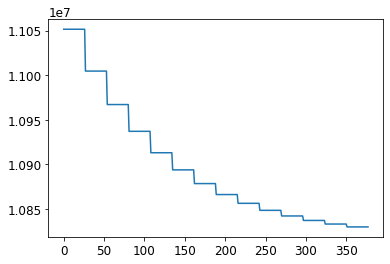

In [230]:
plt.plot(out["il"]["log"][11]["q"])

In [33]:
d["Spol"]

array([0.        , 0.08536185, 0.17072191, 0.25608143, 0.34144131,
       0.42680218, 0.51216433, 0.59752782, 0.68289245, 0.76825774,
       0.85362304, 0.93898747, 1.02435037, 1.10971192, 1.19507253,
       1.2804328 , 1.3657935 , 1.45115561, 1.53652032, 1.62188772,
       1.70725547, 1.79262175, 1.87798567, 1.96334735, 2.04870795,
       2.13406964, 2.21943393, 2.30480007, 2.39016673, 2.47553224,
       2.56089458, 2.64625141, 2.73160104, 2.81694726, 2.90229442,
       2.98764466, 3.07299802, 3.15835247, 3.24370444, 3.32905282,
       3.4143972 , 3.49973502, 3.58506159, 3.67037028, 3.75565722,
       3.84093928, 3.92623807, 4.01157325, 4.09696279, 4.18241603,
       4.26788007, 4.35327292, 4.43851652, 4.52353871, 4.60839553,
       4.69341854, 4.77896882, 4.86538674, 4.95213021, 5.03747269,
       5.12021461, 5.20313064, 5.29502314, 5.37964182, 5.46489965,
       5.54960485, 5.63512172, 5.72038547, 5.80572078, 5.89103631,
       5.97635683, 6.06167645, 6.14699607, 6.23231571, 6.31763

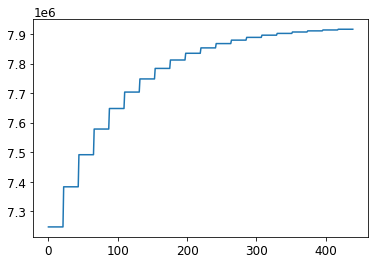

In [17]:
plt.plot(log[67]["q"])

# Read equilibrium file

In [50]:
X, Y = np.meshgrid(eqb["r"], eqb["z"])

MemoryError: Unable to allocate 32.5 GiB for an array with shape (66049, 66049) and data type float64